# Top 3 Models Performance Comparison

This notebook creates visualizations comparing the performance of the top 3 trackbed classification models.

**Visualizations:**
1. **Overlapping Radar Chart** - Macro averages of all 3 models on one chart
2. **Per-Class Performance Comparison** - Detailed comparison across classes
3. **Model Summary Table** - Key metrics overview
4. **Training Curves Comparison** - Training and validation loss and accuracy curves

**Data Source:** Results from `results_top_3/` directory containing performance metrics for models 1, 2, and 3.

In [59]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Set up paths
results_dir = Path('./results_top_3')
output_dir = Path('./model_comparison_plots')
output_dir.mkdir(exist_ok=True)

# Model identifiers
models = ['1', '2', '3']
model_names = ['Pretrained ResNet50 (large ds)', 'VGG 16 (medium ds)', 'Custom CNN Mid (large ds)']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

print(f"Looking for results in: {results_dir.absolute()}")
print(f"Output directory: {output_dir.absolute()}")

Looking for results in: /media/andi/ssd2/dev/code/RAILS/results_top_3
Output directory: /media/andi/ssd2/dev/code/RAILS/model_comparison_plots


In [60]:
def load_model_performance(model_id):
    """Load performance data for a specific model."""
    perf_file = results_dir / model_id / 'per_class_performance.json'
    
    with open(perf_file, 'r') as f:
        data = json.load(f)
    
    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(data['data'], columns=data['columns'])
    return df

def calculate_macro_averages(df):
    """Calculate macro averages from per-class performance data."""
    metrics = {}
    for metric in ['Precision', 'Recall', 'F1-Score', 'Accuracy']:
        if metric in df.columns:
            metrics[metric] = df[metric].mean()
    return metrics

# Load all model data
model_data = {}
macro_averages = {}

for model_id in models:
    try:
        df = load_model_performance(model_id)
        model_data[model_id] = df
        macro_averages[model_id] = calculate_macro_averages(df)
        print(f"✓ Loaded Model {model_id} - Classes: {len(df)}")
    except Exception as e:
        print(f"✗ Error loading Model {model_id}: {e}")

print(f"\nSuccessfully loaded {len(model_data)} models")

✓ Loaded Model 1 - Classes: 5
✓ Loaded Model 2 - Classes: 5
✓ Loaded Model 3 - Classes: 5

Successfully loaded 3 models


In [61]:
# Display macro averages summary
print("\n=== MACRO AVERAGES SUMMARY ===")
summary_data = []

for model_id in models:
    if model_id in macro_averages:
        row = [f"Model {model_id}"]
        for metric in ['Precision', 'Recall', 'F1-Score', 'Accuracy']:
            if metric in macro_averages[model_id]:
                row.append(f"{macro_averages[model_id][metric]:.4f}")
            else:
                row.append("N/A")
        summary_data.append(row)

summary_df = pd.DataFrame(summary_data, columns=['Model', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])
print(summary_df.to_string(index=False))


=== MACRO AVERAGES SUMMARY ===
  Model Precision Recall F1-Score Accuracy
Model 1    0.9866 0.9864   0.9864   0.9946
Model 2    0.9627 0.9624   0.9624   0.9850
Model 3    0.9534 0.9536   0.9535   0.9814



✓ Radar chart saved to: model_comparison_plots/top3_models_radar_comparison.png


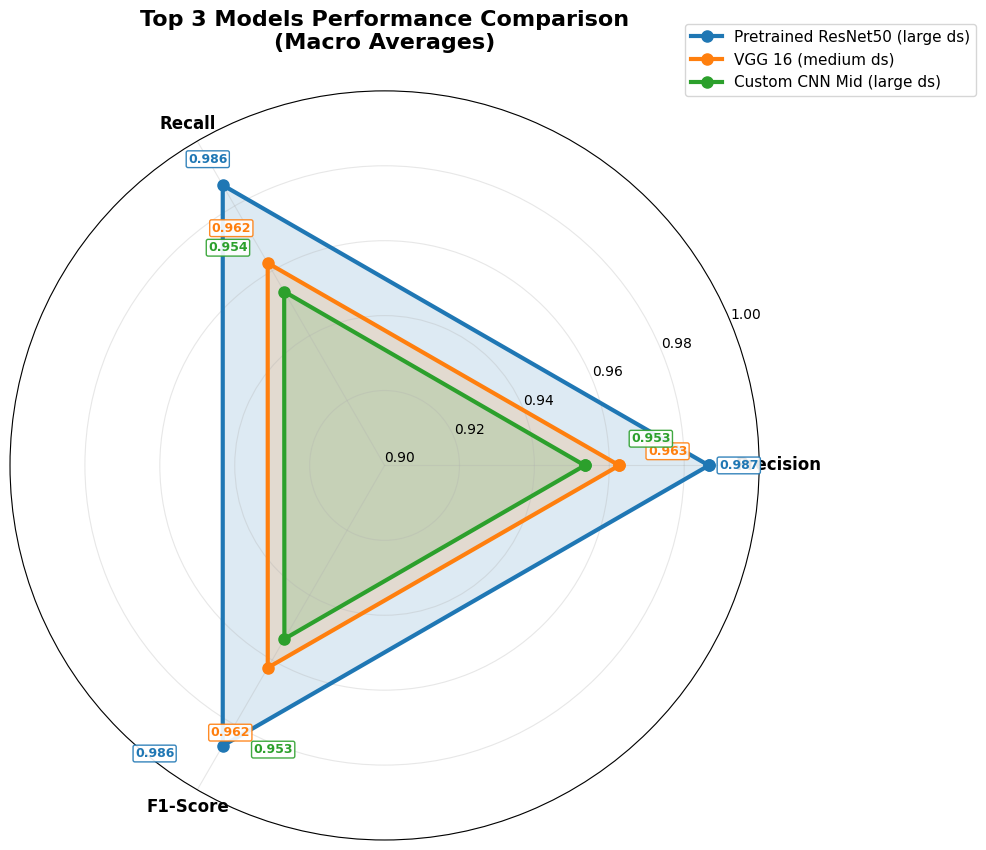

In [62]:
# Create overlapping radar chart for all three models
def create_comparison_radar_chart():
    """Create an overlapping radar chart comparing all three models."""
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Metrics to display (excluding Accuracy as it might be calculated differently)
    radar_metrics = ['Precision', 'Recall', 'F1-Score']
    N = len(radar_metrics)
    
    # Compute angles for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the circle
    
    # Plot each model
    for i, model_id in enumerate(models):
        if model_id not in macro_averages:
            continue
            
        # Get values for this model
        values = []
        for metric in radar_metrics:
            if metric in macro_averages[model_id]:
                values.append(macro_averages[model_id][metric])
            else:
                values.append(0.0)
        
        # Complete the circle
        values += values[:1]
        
        # Plot this model
        ax.plot(angles, values, 'o-', linewidth=3, 
                label=model_names[i], color=colors[i], markersize=8)
        ax.fill(angles, values, alpha=0.15, color=colors[i])
        
        # Add value labels for this model with better positioning
        for j, (angle, value, metric) in enumerate(zip(angles[:-1], values[:-1], radar_metrics)):
            # Calculate better label positioning to avoid overlap
            if metric == 'F1-Score':  # Bottom position - spread labels more
                # Use different radial offsets for each model
                label_radius = value + 0.012 + (i * 0.008)
                # Add angular offset to spread labels horizontally
                angle_offset = (i - 1) * 0.15  # Spread left-center-right
                label_angle = angle + angle_offset
            else:
                # For other positions, use smaller offsets
                label_radius = value + 0.008 + (i * 0.005)
                label_angle = angle + (i * 0.05)
            
            ax.text(label_angle, label_radius, f'{value:.3f}', 
                    ha='center', va='center', fontsize=9, fontweight='bold',
                    color=colors[i],
                    bbox=dict(boxstyle='round,pad=0.15', facecolor='white', 
                             edgecolor=colors[i], alpha=0.9))
    
    # Customize the chart
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_metrics, fontsize=12, fontweight='bold')
    
    # Set scale from 0.9 to 1.0 as requested
    ax.set_ylim(0.9, 1.0)
    ax.set_yticks([0.90, 0.92, 0.94, 0.96, 0.98, 1.0])
    ax.set_yticklabels(['0.90', '0.92', '0.94', '0.96', '0.98', '1.00'], fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
    
    # Title
    ax.set_title('Top 3 Models Performance Comparison\n(Macro Averages)', 
                 fontsize=16, fontweight='bold', pad=30)
    
    plt.tight_layout()
    
    # Save the plot
    output_file = output_dir / 'top3_models_radar_comparison.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Radar chart saved to: {output_file}")
    
    plt.show()
    return fig

# Create the radar chart
radar_fig = create_comparison_radar_chart()

✓ Per-class comparison saved to: model_comparison_plots/top3_models_per_class_comparison.png


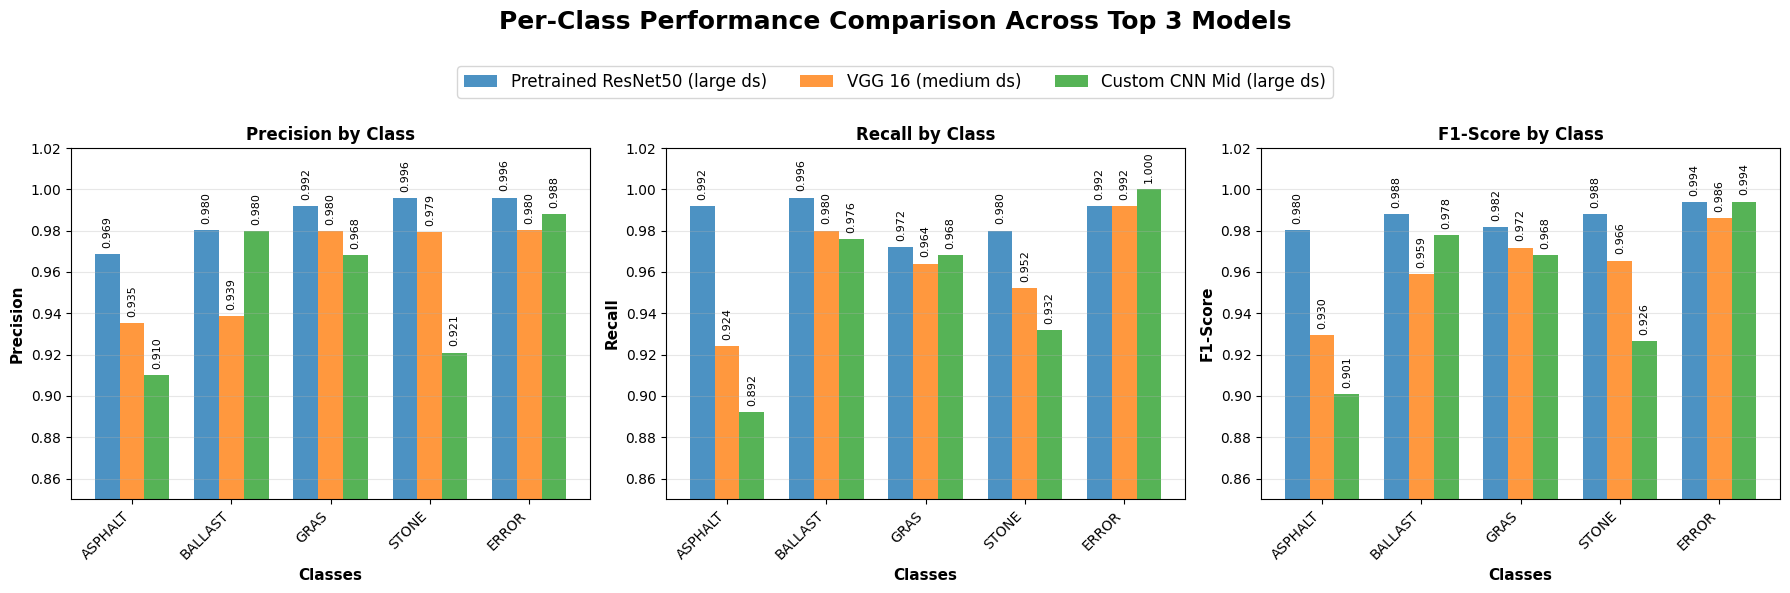

In [73]:
# Create per-class performance comparison
def create_per_class_comparison():
    """Create a bar chart comparing per-class performance across models."""
    
    # Get class names from first model
    first_model = list(model_data.keys())[0]
    classes = model_data[first_model]['Class'].tolist()
    
    metrics_to_plot = ['Precision', 'Recall', 'F1-Score']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx]
        
        x = np.arange(len(classes))
        width = 0.25
        
        for i, model_id in enumerate(models):
            if model_id not in model_data:
                continue
                
            values = model_data[model_id][metric].tolist()
            bars = ax.bar(x + i*width, values, width, 
                         label=model_names[i] if idx == 0 else "", # Only add label to first plot
                         color=colors[i], alpha=0.8)
            
            # Add value labels on bars
            for bar, val in zip(bars, values):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.003,
                        f'{val:.3f}', ha='center', va='bottom', 
                        fontsize=8, rotation=90)
        
        ax.set_xlabel('Classes', fontsize=11, fontweight='bold')
        ax.set_ylabel(f'{metric}', fontsize=11, fontweight='bold')
        ax.set_title(f'{metric} by Class', fontsize=12, fontweight='bold')
        ax.set_xticks(x + width)
        ax.set_xticklabels(classes, rotation=45, ha='right')
        ax.set_ylim(0.85, 1.02)
        ax.grid(True, alpha=0.3, axis='y')
    
    # Add main title at the very top
    fig.suptitle('Per-Class Performance Comparison Across Top 3 Models', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    # Add legend below the title but above the plots
    fig.legend(model_names, loc='upper center', bbox_to_anchor=(0.5, 0.90), 
               ncol=3, fontsize=12, frameon=True)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.75)  # Make room for both title and legend
    
    # Save the plot
    output_file = output_dir / 'top3_models_per_class_comparison.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✓ Per-class comparison saved to: {output_file}")
    
    plt.show()
    return fig

# Create per-class comparison
per_class_fig = create_per_class_comparison()

✓ Summary table saved to: model_comparison_plots/top3_models_summary_table.png


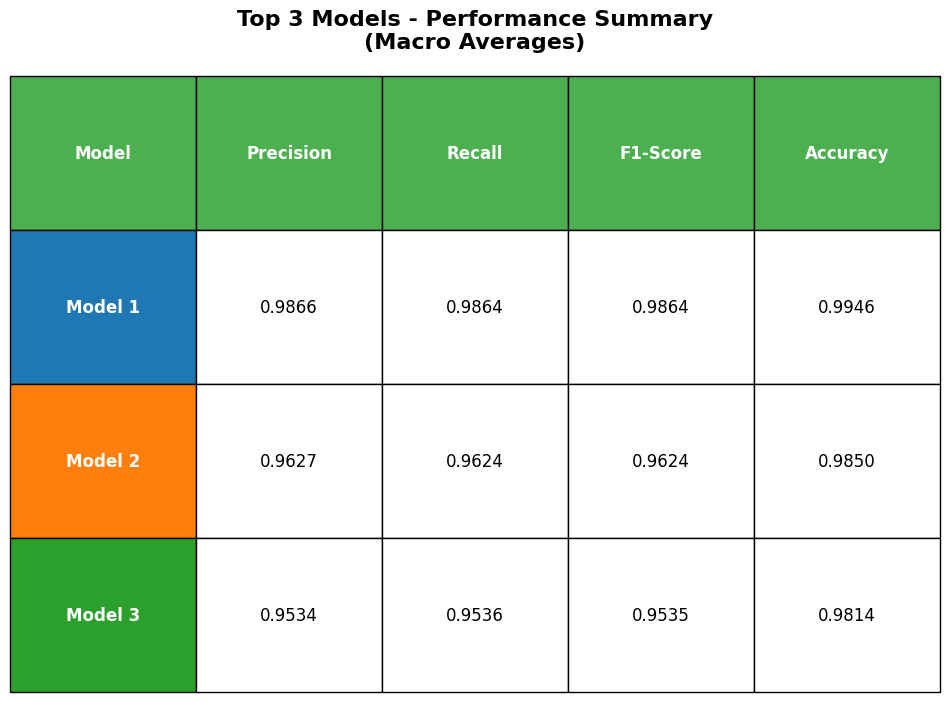

In [64]:
# Create a summary metrics table visualization
def create_summary_table():
    """Create a summary table of key metrics for all models."""
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('tight')
    ax.axis('off')
    
    # Prepare data for table
    table_data = []
    metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
    
    for model_id in models:
        if model_id not in macro_averages:
            continue
        row = [f'Model {model_id}']
        for metric in metrics:
            if metric in macro_averages[model_id]:
                row.append(f"{macro_averages[model_id][metric]:.4f}")
            else:
                row.append('N/A')
        table_data.append(row)
    
    # Create table
    table = ax.table(cellText=table_data,
                    colLabels=['Model'] + metrics,
                    cellLoc='center',
                    loc='center',
                    bbox=[0, 0, 1, 1])
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 2)
    
    # Color code the header
    for i in range(len(metrics) + 1):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color code model rows
    for i, model_id in enumerate(models):
        if model_id in macro_averages:
            table[(i+1, 0)].set_facecolor(colors[i])
            table[(i+1, 0)].set_text_props(weight='bold', color='white')
    
    plt.title('Top 3 Models - Performance Summary\n(Macro Averages)', 
             fontsize=16, fontweight='bold', pad=20)
    
    # Save the plot
    output_file = output_dir / 'top3_models_summary_table.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✓ Summary table saved to: {output_file}")
    
    plt.show()
    return fig

# Create summary table
summary_fig = create_summary_table()

In [65]:
# Optional: Try to load config files for model architecture information
def load_model_configs():
    """Attempt to load configuration files for model details."""
    configs = {}
    
    for model_id in models:
        config_file = results_dir / model_id / 'config.json'
        if config_file.exists():
            try:
                with open(config_file, 'r') as f:
                    configs[model_id] = json.load(f)
                print(f"✓ Loaded config for Model {model_id}")
            except Exception as e:
                print(f"✗ Error loading config for Model {model_id}: {e}")
        else:
            print(f"ℹ No config file found for Model {model_id}")
    
    return configs

# Try to load configs
configs = load_model_configs()

if configs:
    print("\n=== MODEL CONFIGURATIONS ===")
    for model_id, config in configs.items():
        print(f"\nModel {model_id}:")
        for key, value in config.items():
            print(f"  {key}: {value}")
else:
    print("\nNo configuration files found. Using generic model names.")

✓ Loaded config for Model 1
✓ Loaded config for Model 2
✓ Loaded config for Model 3

=== MODEL CONFIGURATIONS ===

Model 1:
  model: PT_MultiClassResNet50_Trackbed
  dataset: MultiLabel_TB_large_08-25.tfrecord

Model 2:
  model: MultiClassVGG16_Trackbed
  dataset: MultiLabel_TB_medium_08-25.tfrecord

Model 3:
  model: CustomCNN_Trackbed_Mid
  dataset: MultiLabel_TB_large_08-25.tfrecord


✓ Loaded training data for Model 1 - 29 epochs
✓ Loaded training data for Model 2 - 30 epochs
✓ Loaded training data for Model 3 - 30 epochs

✓ Training curves saved to: model_comparison_plots/top3_models_training_curves.png

✓ Training curves saved to: model_comparison_plots/top3_models_training_curves.png


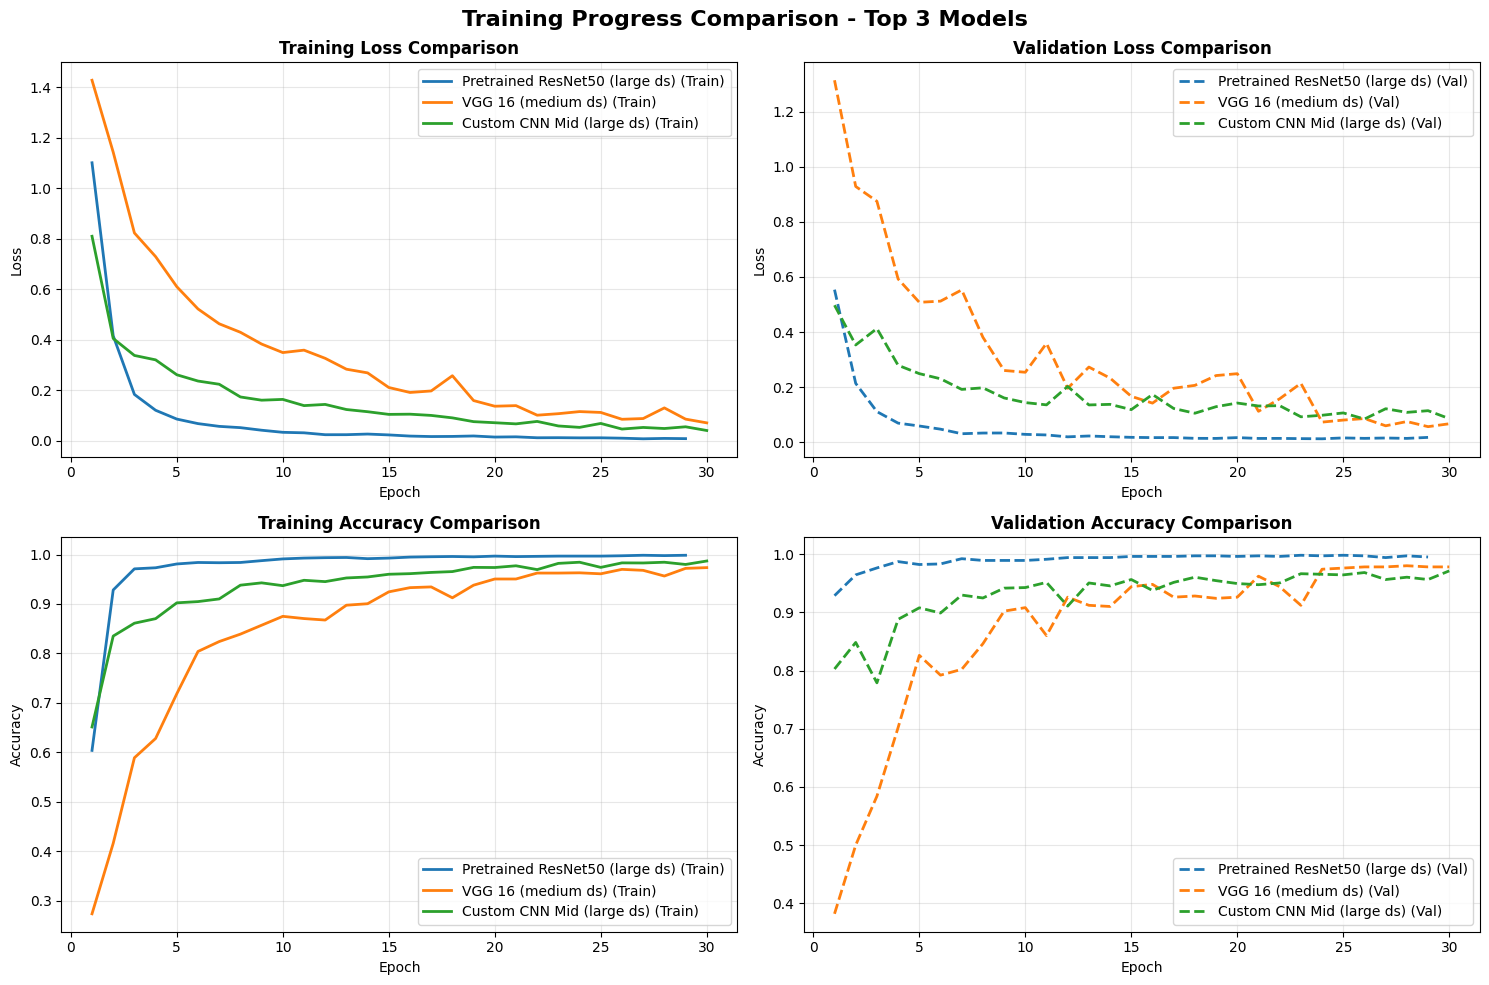

In [ ]:
# Add training curves comparison
def parse_training_log(log_file):
    """Parse training log file to extract epoch metrics."""
    epochs = []
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    try:
        with open(log_file, 'r') as f:
            lines = f.readlines()
        
        for line in lines:
            line = line.strip()
            if 'Epoch' in line and '/' in line:
                # Parse epoch number
                epoch_part = line.split()[1]
                epoch_num = int(epoch_part.split('/')[0])
                epochs.append(epoch_num)
                
                # Parse metrics from the line
                # Look for patterns like 'loss: 0.1234' and 'val_loss: 0.5678'
                import re
                
                loss_match = re.search(r'loss: ([0-9.]+)', line)
                val_loss_match = re.search(r'val_loss: ([0-9.]+)', line)
                acc_match = re.search(r'categorical_accuracy: ([0-9.]+)', line)
                val_acc_match = re.search(r'val_categorical_accuracy: ([0-9.]+)', line)
                
                if loss_match:
                    train_loss.append(float(loss_match.group(1)))
                if val_loss_match:
                    val_loss.append(float(val_loss_match.group(1)))
                if acc_match:
                    train_acc.append(float(acc_match.group(1)))
                if val_acc_match:
                    val_acc.append(float(val_acc_match.group(1)))
    
    except Exception as e:
        print(f"Error parsing log file {log_file}: {e}")
        return None
    
    return {
        'epochs': epochs,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc
    }

def create_training_curves_comparison():
    """Create training curves comparison for all three models."""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Load training data for all models
    training_data = {}
    for model_id in models:
        log_file = results_dir / model_id / 'train.log'
        if log_file.exists():
            data = parse_training_log(log_file)
            if data:
                training_data[model_id] = data
                print(f"✓ Loaded training data for Model {model_id} - {len(data['epochs'])} epochs")
            else:
                print(f"✗ Failed to parse training data for Model {model_id}")
        else:
            print(f"✗ No train.log found for Model {model_id}")
    
    if not training_data:
        print("No training data could be loaded.")
        return None
    
    # Plot 1: Training Loss
    ax1 = axes[0, 0]
    for i, model_id in enumerate(models):
        if model_id in training_data:
            data = training_data[model_id]
            ax1.plot(data['epochs'], data['train_loss'], 
                    color=colors[i], linewidth=2, label=f'{model_names[i]} (Train)')
    
    ax1.set_title('Training Loss Comparison', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Validation Loss
    ax2 = axes[0, 1]
    for i, model_id in enumerate(models):
        if model_id in training_data:
            data = training_data[model_id]
            ax2.plot(data['epochs'], data['val_loss'], 
                    color=colors[i], linewidth=2, linestyle='--', label=f'{model_names[i]} (Val)')
    
    ax2.set_title('Validation Loss Comparison', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Training Accuracy
    ax3 = axes[1, 0]
    for i, model_id in enumerate(models):
        if model_id in training_data:
            data = training_data[model_id]
            ax3.plot(data['epochs'], data['train_acc'], 
                    color=colors[i], linewidth=2, label=f'{model_names[i]} (Train)')
    
    ax3.set_title('Training Accuracy Comparison', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Accuracy')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Validation Accuracy
    ax4 = axes[1, 1]
    for i, model_id in enumerate(models):
        if model_id in training_data:
            data = training_data[model_id]
            ax4.plot(data['epochs'], data['val_acc'], 
                    color=colors[i], linewidth=2, linestyle='--', label=f'{model_names[i]} (Val)')
    
    ax4.set_title('Validation Accuracy Comparison', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Accuracy')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Training Progress Comparison - Top 3 Models', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Save the plot
    output_file = output_dir / 'top3_models_training_curves.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Training curves saved to: {output_file}")
    
    plt.show()
    return fig

# Create training curves comparison
training_fig = create_training_curves_comparison()

✓ Combined training plot saved to: model_comparison_plots/top3_models_combined_training.png


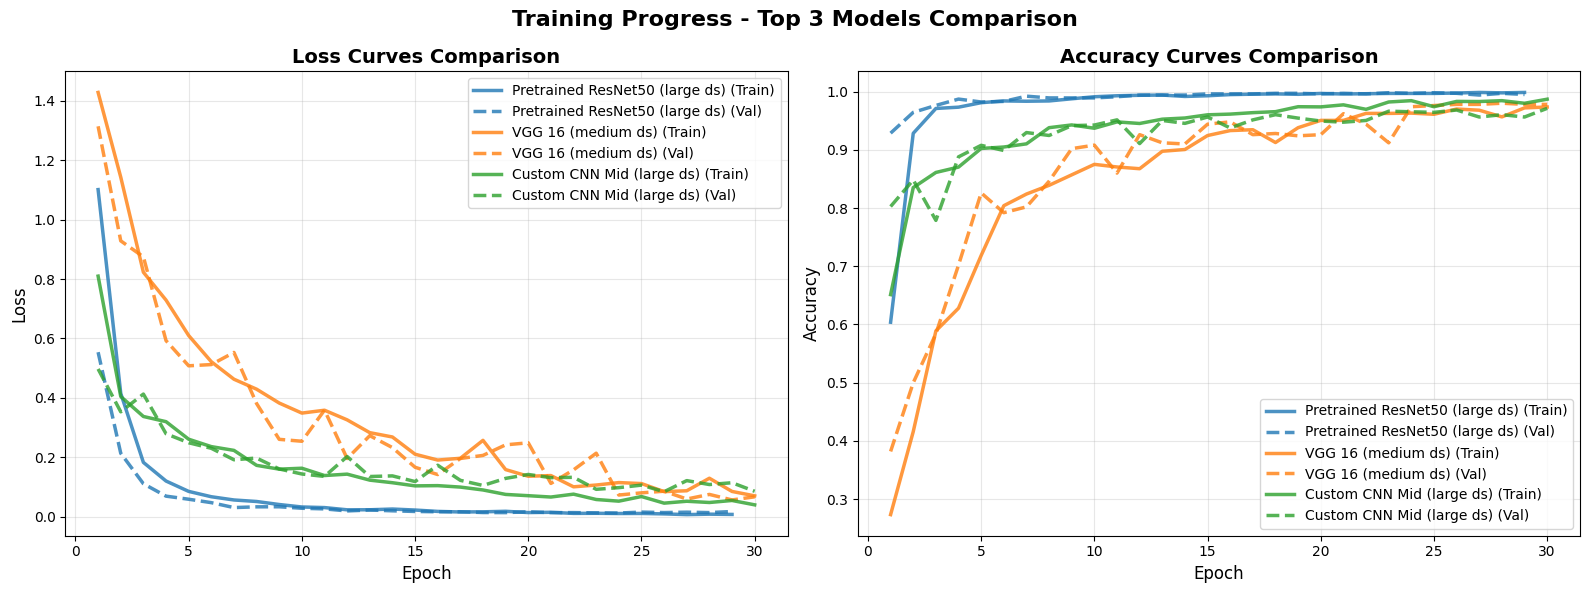

In [67]:
# Create combined training curves (all metrics on one plot)
def create_combined_training_plot():
    """Create a combined plot showing both loss and accuracy for all models."""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Load training data if not already loaded
    training_data = {}
    for model_id in models:
        log_file = results_dir / model_id / 'train.log'
        if log_file.exists():
            data = parse_training_log(log_file)
            if data:
                training_data[model_id] = data
    
    if not training_data:
        print("No training data available for combined plot.")
        return None
    
    # Loss plot (left)
    for i, model_id in enumerate(models):
        if model_id in training_data:
            data = training_data[model_id]
            # Training loss - solid line
            ax1.plot(data['epochs'], data['train_loss'], 
                    color=colors[i], linewidth=2.5, 
                    label=f'{model_names[i]} (Train)', alpha=0.8)
            # Validation loss - dashed line
            ax1.plot(data['epochs'], data['val_loss'], 
                    color=colors[i], linewidth=2.5, linestyle='--', 
                    label=f'{model_names[i]} (Val)', alpha=0.8)
    
    ax1.set_title('Loss Curves Comparison', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Accuracy plot (right)
    for i, model_id in enumerate(models):
        if model_id in training_data:
            data = training_data[model_id]
            # Training accuracy - solid line
            ax2.plot(data['epochs'], data['train_acc'], 
                    color=colors[i], linewidth=2.5, 
                    label=f'{model_names[i]} (Train)', alpha=0.8)
            # Validation accuracy - dashed line
            ax2.plot(data['epochs'], data['val_acc'], 
                    color=colors[i], linewidth=2.5, linestyle='--', 
                    label=f'{model_names[i]} (Val)', alpha=0.8)
    
    ax2.set_title('Accuracy Curves Comparison', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Training Progress - Top 3 Models Comparison', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Save the plot
    output_file = output_dir / 'top3_models_combined_training.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✓ Combined training plot saved to: {output_file}")
    
    plt.show()
    return fig

# Create combined training plot
combined_training_fig = create_combined_training_plot()

## Summary

This notebook has generated the following visualizations:

1. **Overlapping Radar Chart** (`top3_models_radar_comparison.png`):
   - Shows macro averages for Precision, Recall, and F1-Score
   - Scale optimized for high-performance models (0.9-1.0)
   - All three models overlapped with different colors

2. **Per-Class Performance Comparison** (`top3_models_per_class_comparison.png`):
   - Detailed breakdown by class for each metric
   - Side-by-side comparison across all models

3. **Summary Table** (`top3_models_summary_table.png`):
   - Clean table format with key metrics
   - Color-coded by model

4. **Training Curves Comparison** (`top3_models_training_curves.png`):
   - Training and validation loss and accuracy curves
   - Comparison across all models

5. **Combined Training Plot** (`top3_models_combined_training.png`):
   - Combined plot showing both loss and accuracy for all models

All visualizations are saved as high-resolution PNG files in the `model_comparison_plots/` directory.

## Additional Comparison: Model 1 vs ResNet Medium

This section provides a focused comparison between Model 1 (Pretrained ResNet50 on large dataset) and ResNet Medium model using a radar chart with enhanced scale (0.95-1.0) for detailed performance analysis.

In [68]:
# Load ResNet_medium data for comparison
def load_resnet_medium_data():
    """Load performance data for ResNet_medium model."""
    perf_file = results_dir / 'ResNet_medium' / 'per_class_performance.json'
    
    try:
        with open(perf_file, 'r') as f:
            data = json.load(f)
        
        # Convert to DataFrame for easier manipulation
        df = pd.DataFrame(data['data'], columns=data['columns'])
        return df
    except Exception as e:
        print(f"Error loading ResNet_medium data: {e}")
        return None

# Load the ResNet_medium data
resnet_medium_df = load_resnet_medium_data()

if resnet_medium_df is not None:
    resnet_medium_averages = calculate_macro_averages(resnet_medium_df)
    print(f"✓ Loaded ResNet_medium data - Classes: {len(resnet_medium_df)}")
    
    # Display comparison summary
    print("\n=== MODEL 1 vs RESNET_MEDIUM COMPARISON ===")
    comparison_data = []
    
    # Model 1 data
    if '1' in macro_averages:
        row1 = ['Pretrained ResNet50 (large ds)']
        for metric in ['Precision', 'Recall', 'F1-Score', 'Accuracy']:
            if metric in macro_averages['1']:
                row1.append(f"{macro_averages['1'][metric]:.4f}")
            else:
                row1.append('N/A')
        comparison_data.append(row1)
    
    # ResNet_medium data
    row2 = ['ResNet Medium']
    for metric in ['Precision', 'Recall', 'F1-Score', 'Accuracy']:
        if metric in resnet_medium_averages:
            row2.append(f"{resnet_medium_averages[metric]:.4f}")
        else:
            row2.append('N/A')
    comparison_data.append(row2)
    
    comparison_df = pd.DataFrame(comparison_data, columns=['Model', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])
    print(comparison_df.to_string(index=False))
else:
    print("✗ Could not load ResNet_medium data")

✓ Loaded ResNet_medium data - Classes: 5

=== MODEL 1 vs RESNET_MEDIUM COMPARISON ===
                         Model Precision Recall F1-Score Accuracy
Pretrained ResNet50 (large ds)    0.9866 0.9864   0.9864   0.9946
                 ResNet Medium    0.9850 0.9848   0.9848   0.9939



✓ Model 1 vs ResNet Medium radar chart saved to: model_comparison_plots/model1_vs_resnet_medium_radar.png


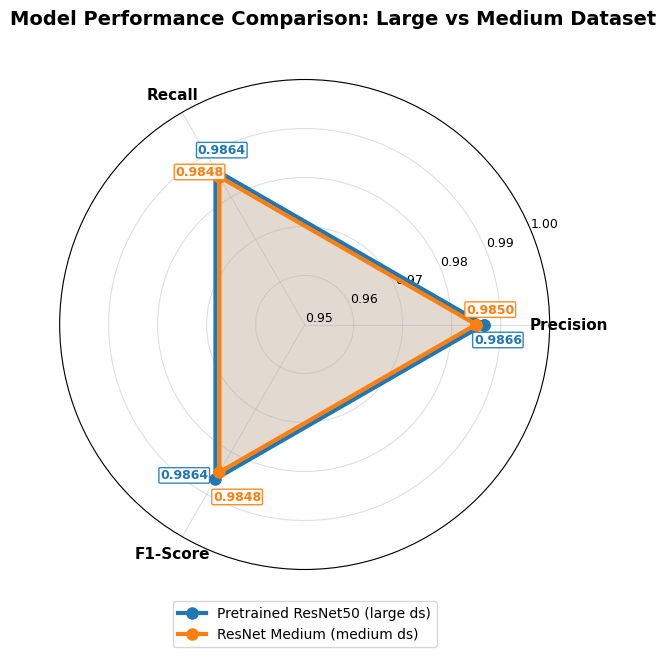

In [74]:
# Create focused radar chart comparison
def create_model1_vs_resnet_medium_radar():
    """Create a radar chart comparing Model 1 and ResNet_medium with enhanced scale."""
    
    if resnet_medium_df is None or '1' not in macro_averages:
        print("Cannot create comparison - missing data")
        return None
    
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(projection='polar'))  # Made more compact
    
    # Metrics to display
    radar_metrics = ['Precision', 'Recall', 'F1-Score']
    N = len(radar_metrics)
    
    # Compute angles for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the circle
    
    # Model comparison data
    models_comparison = [
        ('1', 'Pretrained ResNet50 (large ds)', '#1f77b4'),
        ('ResNet_medium', 'ResNet Medium (medium ds)', '#ff7f0e')
    ]
    
    # Plot each model
    for model_id, model_name, color in models_comparison:
        if model_id == '1':
            model_averages = macro_averages['1']
        else:
            model_averages = resnet_medium_averages
        
        # Get values for this model
        values = []
        for metric in radar_metrics:
            if metric in model_averages:
                values.append(model_averages[metric])
            else:
                values.append(0.0)
        
        # Complete the circle
        values += values[:1]
        
        # Plot this model
        ax.plot(angles, values, 'o-', linewidth=3, 
                label=model_name, color=color, markersize=8)
        ax.fill(angles, values, alpha=0.15, color=color)
        
        # Add value labels with better positioning
        for j, (angle, value, metric) in enumerate(zip(angles[:-1], values[:-1], radar_metrics)):
            # Calculate label positioning to avoid overlap
            if metric == 'Precision':  # Right side
                label_radius = value + 0.003
                if model_id == '1':
                    angle_offset = -0.08
                else:
                    angle_offset = 0.08
                label_angle = angle + angle_offset
            elif metric == 'Recall':  # Top left
                label_radius = value + 0.003
                if model_id == '1':
                    angle_offset = -0.08
                else:
                    angle_offset = 0.08
                label_angle = angle + angle_offset
            else:  # F1-Score - Bottom
                label_radius = value + 0.003
                if model_id == '1':
                    angle_offset = -0.15  # Spread wider for bottom labels
                else:
                    angle_offset = 0.15
                label_angle = angle + angle_offset
            
            ax.text(label_angle, label_radius, f'{value:.4f}', 
                    ha='center', va='center', fontsize=9, fontweight='bold',
                    color=color,
                    bbox=dict(boxstyle='round,pad=0.1', facecolor='white', 
                             edgecolor=color, alpha=0.9))
    
    # Customize the chart
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_metrics, fontsize=11, fontweight='bold')
    
    # Set enhanced scale from 0.95 to 1.0
    ax.set_ylim(0.95, 1.0)
    ax.set_yticks([0.95, 0.96, 0.97, 0.98, 0.99, 1.0])
    ax.set_yticklabels(['0.95', '0.96', '0.97', '0.98', '0.99', '1.00'], fontsize=9)
    ax.grid(True, alpha=0.4)
    
    # Add title at the top
    fig.suptitle('Model Performance Comparison: Large vs Medium Dataset', 
                 fontsize=14, fontweight='bold', y=0.95)
    
    # Add legend below the title but above the plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), 
             ncol=1, fontsize=10, frameon=True)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.15)  # Make room for title and legend
    
    # Save the plot
    output_file = output_dir / 'model1_vs_resnet_medium_radar.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Model 1 vs ResNet Medium radar chart saved to: {output_file}")
    
    plt.show()
    return fig

# Create the focused comparison radar chart
focused_radar_fig = create_model1_vs_resnet_medium_radar()

✓ Detailed comparison table saved to: model_comparison_plots/model1_vs_resnet_medium_table.png


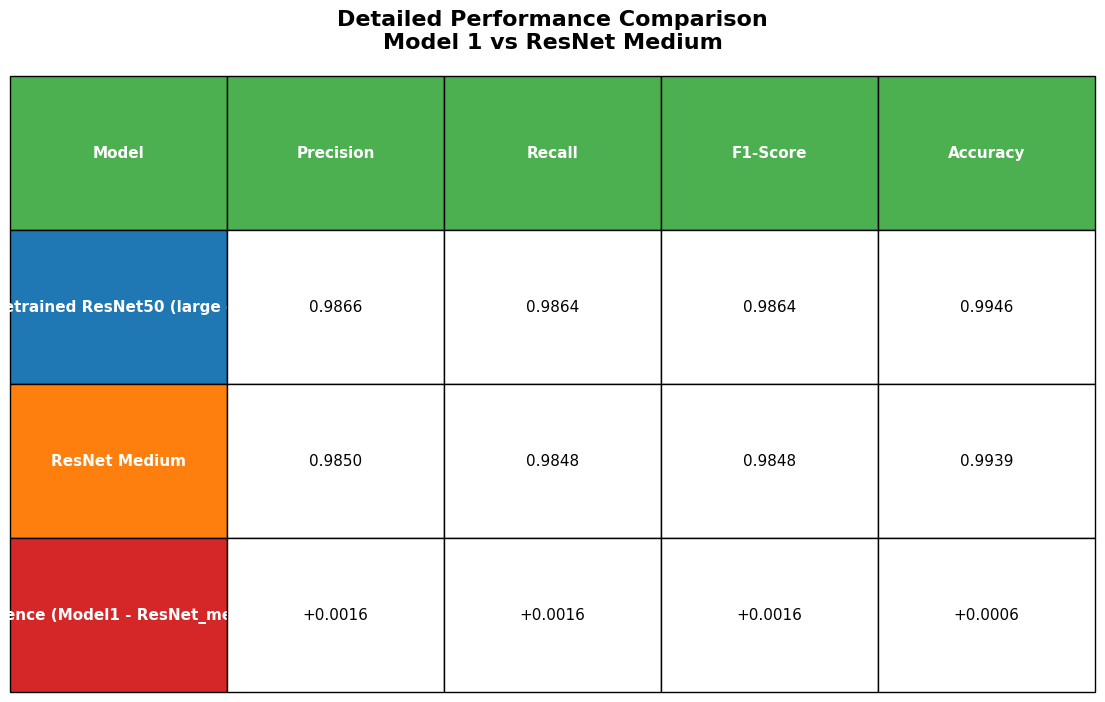

In [70]:
# Create detailed metrics comparison table
def create_detailed_comparison_table():
    """Create a detailed comparison table for Model 1 vs ResNet Medium."""
    
    if resnet_medium_df is None or '1' not in macro_averages:
        print("Cannot create detailed comparison - missing data")
        return None
    
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.axis('tight')
    ax.axis('off')
    
    # Prepare detailed comparison data
    metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
    table_data = []
    
    # Model 1 row
    row1 = ['Pretrained ResNet50 (large ds)']
    for metric in metrics:
        if metric in macro_averages['1']:
            row1.append(f"{macro_averages['1'][metric]:.4f}")
        else:
            row1.append('N/A')
    table_data.append(row1)
    
    # ResNet Medium row
    row2 = ['ResNet Medium']
    for metric in metrics:
        if metric in resnet_medium_averages:
            row2.append(f"{resnet_medium_averages[metric]:.4f}")
        else:
            row2.append('N/A')
    table_data.append(row2)
    
    # Difference row
    row3 = ['Difference (Model1 - ResNet_medium)']
    for metric in metrics:
        if (metric in macro_averages['1'] and metric in resnet_medium_averages):
            diff = macro_averages['1'][metric] - resnet_medium_averages[metric]
            row3.append(f"{diff:+.4f}")
        else:
            row3.append('N/A')
    table_data.append(row3)
    
    # Create table
    table = ax.table(cellText=table_data,
                    colLabels=['Model'] + metrics,
                    cellLoc='center',
                    loc='center',
                    bbox=[0, 0, 1, 1])
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1.2, 2.5)
    
    # Color code the header
    for i in range(len(metrics) + 1):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color code model rows
    table[(1, 0)].set_facecolor('#1f77b4')  # Model 1 - blue
    table[(1, 0)].set_text_props(weight='bold', color='white')
    table[(2, 0)].set_facecolor('#ff7f0e')  # ResNet Medium - orange
    table[(2, 0)].set_text_props(weight='bold', color='white')
    table[(3, 0)].set_facecolor('#d62728')  # Difference - red
    table[(3, 0)].set_text_props(weight='bold', color='white')
    
    plt.title('Detailed Performance Comparison\nModel 1 vs ResNet Medium', 
             fontsize=16, fontweight='bold', pad=20)
    
    # Save the plot
    output_file = output_dir / 'model1_vs_resnet_medium_table.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✓ Detailed comparison table saved to: {output_file}")
    
    plt.show()
    return fig

# Create detailed comparison table
detailed_table_fig = create_detailed_comparison_table()

## Analysis Summary: Model 1 vs ResNet Medium

The focused comparison between Model 1 (Pretrained ResNet50 on large dataset) and ResNet Medium provides insights into:

- **Performance differences** across key metrics (Precision, Recall, F1-Score)
- **Enhanced scale visualization** (0.95-1.0) for detailed analysis of high-performing models
- **Quantitative differences** showing exact performance gaps

The radar chart uses an enhanced scale to highlight subtle but potentially important differences between these two high-performing models, while the detailed table provides exact numerical comparisons including difference calculations.